# **Stock market news feed semantic analysis** *(Baseline LSTM)*

## **A projekt előkészítése**

A Drive csatlakoztatása a szükséges fájlok későbbi betöltésére.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A reddit-es híreket tartalmazó dataset beolvasása. Ez az adathalmaz nem saját adathalamaz, forrás: Sun, J. (2016, August). Daily News for Stock Market Prediction, Version 1. Retrieved 2021.02.19. from https://www.kaggle.com/aaron7sun/stocknews

In [4]:
# Copy the dataset to the local environment
!cp "/content/drive/MyDrive/Combined_News_DJIA.csv" "Combined_News_DJIA.csv"

In [5]:
# Check the copy is succesfull -> good if no assertation error
read = !ls
assert read[0].find("Combined_News_DJIA.csv") != -1

A verziószámok ellenőrzése.

In [6]:
#!pip list

Látható, hogy a torchtext verziója nem megfelelő az alkalmazásra, ezért frissítem.

In [7]:
!pip install torchtext==0.4.0

     |████████████████████████████████| 61kB 3.3MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


A szükséges könyvtárak betöltése a projekt egészéhez.

In [8]:
# Import the libraries 
import pandas as pd
import numpy as np
import pandas_datareader as web
import matplotlib.pyplot as plt
import string
import time
import torch.optim as optim
import torch.nn as nn
import torch
from torchtext import data
from sklearn.utils import shuffle
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize  
from wordcloud import WordCloud
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import sklearn.metrics as metrics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


A következőkben a projektben használt makrókat definiálom.

In [9]:
# Number of merged news into one string
ROWS = 8

# The label column 
LABEL_COLUMN = 0

# Shuffle cycle number for the dataframe
SHUFFLE_CYCLE = 500

# Numpy random seed
NP_SEED = 1234

# Torch seed
TORCH_SEED = 1234

# Train percentage (train + valid)
TRAIN_SPLIT = 0.8

# Only validation split
VALIDATION_SPLIT = 0.1

# Vocabulary size
MAX_VOCAB_SIZE = 10000

# Batch size for input
BATCH_SIZE = 32

# LSTM embedding layer dimension
EMBEDDING_DIM = 100

# LSTM hidden layer dimension
HIDDEN_DIM = 128

# LSTM output layer dimension
OUTPUT_DIM = 1

# LSTM layer(s) number
N_LAYERS = 4

# LSTM bidirectional choose
BIDIRECTIONAL = True

# LSTM dropout
DROPOUT = 0.25

# Epoch number
N_EPOCHS = 500

# Create new vocab
NEW_VOCAB = True

# Freeze embedding layer weigths
FREEZE_EMB = False

# n value of n-gram model
N_GRAM = True
N_VALUE_RANGE_START = 3
N_VALUE_RANGE_END = 5

A random generátorok seed-jének beállítása a projekt eredményeinek reprodukálhatósága érdekében.

In [10]:
rs = RandomState(MT19937(SeedSequence(NP_SEED)))
torch.manual_seed(TORCH_SEED)
np.random.seed(NP_SEED)

Globális változók beállítása a determinisztikus futás és a reprodukálhatóság érdekében.

In [11]:
torch.backends.cudnn.deterministic = True

if torch.cuda.is_available():
  torch.cuda.manual_seed_all(TORCH_SEED)

## **A részvény árfolyam elemzése**

A DJIA részvényhez tartozó árfolyam adatok letöltése 2008-06-08 és 2016-07-01 között, majd jellemzőinek a bemutatása következik. Ez az időhalmaz tartozik a korábban említett reddit-es adathalmazhoz.

In [12]:
# Load the stock data
df_stock = web.DataReader("DJIA", data_source="yahoo", start="2008-08-08", 
                          end="2016-07-01")
 
# Show the stock data
df_stock

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-08-08,11808.490234,11344.230469,11432.089844,11734.320312,4966810000,11734.320312
2008-08-11,11933.549805,11580.190430,11729.669922,11782.349609,5067310000,11782.349609
2008-08-12,11830.389648,11541.429688,11781.700195,11642.469727,4711290000,11642.469727
2008-08-13,11689.049805,11377.370117,11632.809570,11532.959961,4787600000,11532.959961
2008-08-14,11744.330078,11399.839844,11532.070312,11615.929688,4064000000,11615.929688
...,...,...,...,...,...,...
2016-06-27,17355.210938,17005.439453,17355.210938,17140.240234,5431220000,17140.240234
2016-06-28,17453.929688,17174.960938,17190.509766,17409.720703,4385810000,17409.720703
2016-06-29,17737.380859,17456.019531,17456.019531,17694.679688,4241740000,17694.679688


Az árfolyamhalmaz metrikái az alábbiakban kiolvasható.

In [13]:
# Metrics for the data
df_stock.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1989.000000,1989.000000,1989.000000,1989.000000,1.989000e+03,1989.000000
mean,13578.978218,13338.995433,13459.334488,13463.026799,4.142490e+09,13463.026799
std,3141.614427,3145.966243,3143.413033,3143.992817,1.234396e+09,3143.992817
min,6758.439941,6440.080078,6547.009766,6547.049805,1.025000e+09,6547.049805
25%,11041.019531,10788.769531,10907.339844,10913.379883,3.364080e+09,10913.379883
50%,13119.120117,12931.629883,13022.049805,13025.580078,3.870040e+09,13025.580078
75%,16595.740234,16358.570312,16477.699219,16478.410156,4.659740e+09,16478.410156
max,18421.130859,18212.570312,18315.060547,18312.390625,1.145623e+10,18312.390625


A napi záró árfolyam ábrázolása.

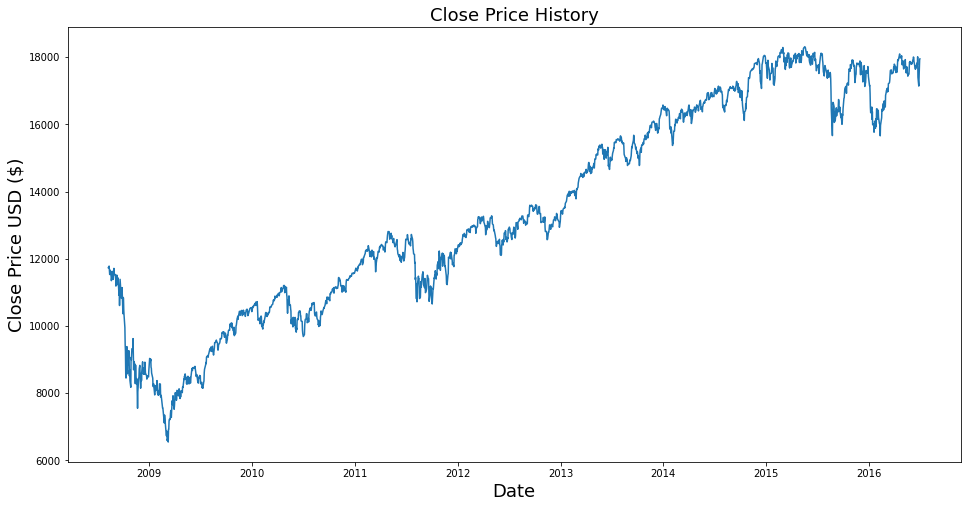

In [14]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title("Close Price History", fontsize = 18)
plt.plot(df_stock["Close"])
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price USD ($)", fontsize = 18)
plt.show()

A napi kereskedett mennyiségek megjelenítése.

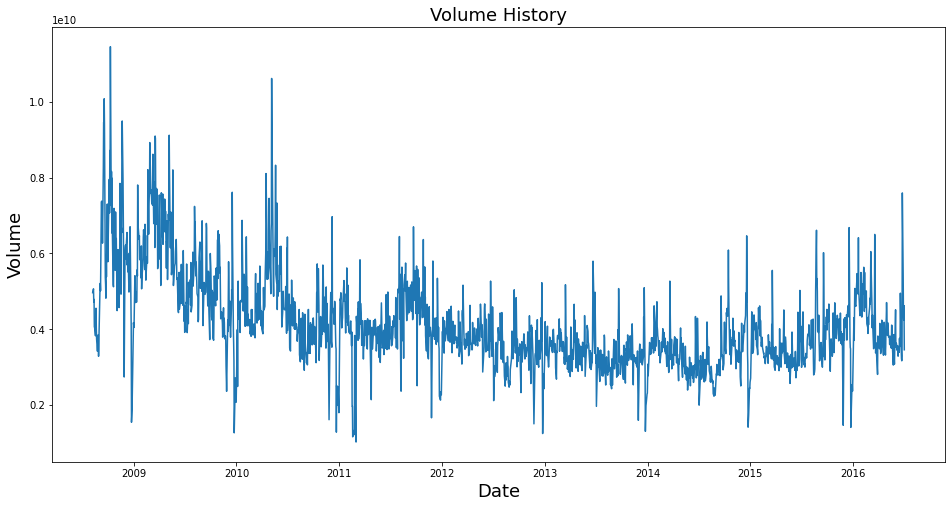

In [15]:
# Visualize the volume history
plt.figure(figsize=(16,8))
plt.title("Volume History", fontsize = 18)
plt.plot(df_stock["Volume"])
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Volume", fontsize = 18)
plt.show()

A továbbiakban a további elemzéshez a mozgó átlagot fogom meghatározni több időszakot alapként véve.

In [16]:
# Calculate moving average for 10, 20, 50 days
ma_day = [10, 20, 50]

for ma in ma_day:
  column_name = f"MA for {ma} days"
  df_stock[column_name] = df_stock["Adj Close"].rolling(ma).mean()

# Check of the column names
print(df_stock.columns)

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'MA for 10 days',
       'MA for 20 days', 'MA for 50 days'],
      dtype='object')


A mozgó átlagok ábrázolása egy diagramban.

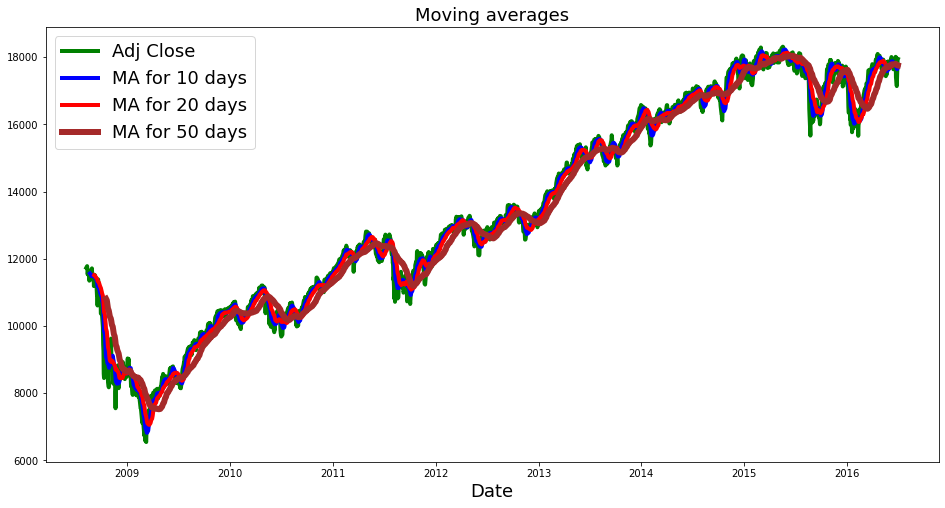

In [17]:
# Visualize the moving averages
plt.figure(figsize=(16,8))
plt.title("Moving averages", fontsize = 18)
plt.plot(df_stock["Adj Close"], color = "green", linewidth = 4,
         label = "Adj Close")
plt.plot(df_stock["MA for 10 days"], color = "blue", linewidth = 4,
         label = "MA for 10 days")
plt.plot(df_stock["MA for 20 days"], color = "red", linewidth = 4,
         label = "MA for 20 days")
plt.plot(df_stock["MA for 50 days"], color = "brown", linewidth = 6, 
         label = "MA for 50 days")
plt.xlabel("Date",fontsize = 18)
plt.legend(fontsize = 18)
plt.show()

## **A hírek szentimentális analízise**

### A szöveg előkészítése

A reddit-es híreket tartalmazó adathalmaz betöltése. A hírek 2008-08-08-tól 2016-07-01-ig tartanak.

In [18]:
# Load the dataset 
df_combined = pd.read_csv('Combined_News_DJIA.csv', index_col = "Date")

# Show the dataframe
df_combined

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel c

A következőkben az esetleges adat nélküli napokat, illetve cellákat keresem meg és helyettesítem őket egy üres sztringgel. Ez a későbbi szövegfeldolgozás hibamentességéhez szükséges. Először a keresés következik.

In [19]:
# Find the cells with NaN and after the rows for them
is_NaN = df_combined.isnull()
row_has_NaN = is_NaN.any(axis = 1)
rows_with_NaN = df_combined[row_has_NaN]

rows_with_NaN

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-09-15,1,b'The Church of Scientology won\'t be dissolve...,b'New virus from rats can kill 80 per cent of ...,b'The gruesome spectacle of dolphins being sla...,b'The End of Innocence in Afghanistan: \'The G...,b'France approves Internet piracy bill',b'The Rural Doctors Association says right now...,b'Al Jazeera English - Africa - Shabab to aven...,"b""How Sri Lanka governs through detentions - S...",b'Two months after the Pakistani Army wrested ...,b'N. Korean cargo ship repels pirates off Soma...,b'Canada: Stephen Harper attempts to prop up r...,b'New geological data provides hope for claims...,b'Ukraine set to block Elton John adoption bec...,b'German plane makes emergency landing',b'Street artist catches chief of the Israeli a...,b'In an equine echo of the controversy surroun...,b'UPDATE: 5-New York homes raided in terrorism...,b'Population Growth Impeding Progress on the M...,b'Global Population to Reach 7 Billion by 2011',b'Government Funded Feminist Porn ',b'Can someone enlighten me re:Holy Land disput...,b'Human Rights Watch official suspended for co...,NaN,NaN,NaN
2009-12-24,1,b'Woman knocks down Pope Benedict at Christmas...,b'Ugandan President Museveni says he will bloc...,"b""Venezuela's Chavez threatens to kick out car...",b'Woman who knocked down pope had pasta in her...,"b'450 people from 21 countries, including 30 f...",b'Chvez declares Angel Falls is no more: World...,b'Drug tests catch out 10 police (UK)',"b'Once the worlds fourth-largest lake, the Ara...","b""Cool Saudi Feminist calls for woman's right ...","b'According to satellite surveys, as much as 8...",b'Italian Prime Minister Silvio Berlusconi has...,"b""Don't blame the system for winter travel cha...",b'Christmas Eve around the world included the ...,b'Pope knocked down before Xmas mass',b'The solar salesman who put his cow on the ma...,b'Pig farts spark Australia gas scare - I shit...,b'Bin Laden daughter flees to Saudi embassy in...,b'Traumatic Brain Injuries: Growing evidence ...,b'The Pakistan Supreme Court has ordered the P...,"b""Here's a video the Taliban released this mor...",b'Fireworks set off aboard airliner',"b'Five VA men may face terrorism charges, Paki...","b""Ayatollah Montazeri's Legacy: In death he m...",NaN,NaN
2011-04-21,1,"Director of ""Restrepo"" and Photographer Chris ...",Everyone within 20km of Fukushima will be forc...,Bahrain: Activist Zaynab Al-Khawaja's letter t...,"More than 80,000 people are claiming incapacit...",Libya: 'mission creep' claims as UK sends in m...,Japan considers banning access to evacuation zone,Chinese oil giant Sinopec has stopped exportin...,6.0-magnitude earthquake strikes off east coas...,Next war in line: At least 20 South Sudanese a...,Bahraini protester ends hunger strike after be...,China tries to scare motorists into safer driving,Leaked Report Shows England Hit With Three Nuc...,Japans cyclone season approaches.,Have Oman and Qatar escaped the Arab revolts?,Rioters torch Australia asylum seeker detentio...,Russian migration official fired in racism row...,Small amounts of radioactive iodine found in b...,"War photographer, Oscar-nominated film directo...",Effeminate boys are being sent to a special ca...,Japan Government Declares 12-Mile Area Around ...,TEPCO admitted Wednesday that nuclear fuel in ...,Fukushima evacuees face arrest if they return ...,Prince Charles wins some kind of a record,NaN,NaN


Az üres cellák kicserélése üres sztringekre, majd annak ellenőrzése, hogy nincs már üres cella. Erre a célra assert függvényt használok, ha lenne esetleg üres cella, akkor azt assertation hibaüzenet jelezné.

In [20]:
# Replace them
df_combined = df_combined.replace(np.nan, " ")

# Check the process
is_NaN = df_combined.isnull()
row_has_NaN = is_NaN.any(axis = 1)
rows_with_NaN = df_combined[row_has_NaN]

assert len(rows_with_NaN) is 0

# Show the dataset
df_combined

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel c

In [21]:
# the last 10 day save out for testing and comparing the models
df_for_test = df_combined.tail(10)
df_combined.drop(df_combined.tail(10).index,inplace=True) # drop last n rows

In [22]:
df_for_test

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-20,1,A staggering 87 percent of Venezuelans say the...,Two corporate whistleblowers may enter into pl...,"Poland, together with Russia, Iran, and severa...",Three environmental activists were killed per ...,"Ontario funeral business dissolves the dead, p...",New Declassified Documents Reveal How CIA Abus...,Tens of thousands of people gathered in swelte...,Japan's dementia crisis hits record levels as ...,"Icelands Hekla volcano, a very popular tourist...",Corbyn pledges to kill TTIP if elected,Venezuelans Ransack Stores as Hunger Grips the...,Rome elects first female mayor,Saudi Arabia and Kuwait angry about Hillary Cl...,Professor Dismissed for Insulting Turkey's Pre...,Russian soldier dies in Syria after preventing...,"Three dead, 45 injured as labor union clashes ...",Indonesia vows to stand firm after skirmishes ...,A study of ocean plankton has shown that an in...,Australia taxes foreign home buyers as afforda...,Paris isn't happy about Amazon's one-hour deli...,Australian man pleads guilty to making sexual ...,Trudeau condemns killing of 14 Canadian Embass...,Vladimir Putin is considering selling part of ...,An elephant has survived being shot in the hea...,Wikileaks founder Julian Assange marks 5 years...
2016-06-21,1,An Australian athlete who has competed in six ...,Russian state television accidentally broadcas...,"In 2015, 50 environmentalists were killed in B...",China's plan to cut meat consumption by 50% ch...,Coral bleaching event now biggest in history ...,Super-rich quaff champagne in Venezuela countr...,Hong Kong bookseller refuses to be silenced af...,Chinese prosecutors have successfully sued a c...,A London-based advocacy group says it has docu...,Erdogan loses appeal against German media boss,Chinese supercomputer is the world's fastest ...,7-Eleven operator handed record penalty of mor...,A Honduran military unit trained by US was ord...,African Union plans to introduce single passpo...,More refugees became citizens of Canada than a...,Turkey charges Reporters Without Borders press...,Brussels: Bomb alert at shopping centre sparks...,Australian Paralympian Liesl Tesch robbed at g...,China issues orders to demolish Buddhist 'town...,Gazans squeezed by triple taxes as Hamas repla...,US and Russian fighters in dramatic showdown o...,Rising Tide of 'Politically Acceptable' Killin...,Mexico teachers protest: Six people are dead a...,Canada is set to launch a paid whistleblower p...,Russian football fan leader Alexander Shprygin...
2016-06-22,0,German government agrees to ban fracking indef...,Teenage recruits were raped by staff and force...,Pakistan is selling nuclear materials to N Kor...,Amazon jaguar shot dead at Olympic torch ceremony,Mexican flags raised around Donald Trump's gol...,EU smashes 2020 emissions target six years ear...,Police kill eight striking Mexican teachers as...,Pro-choice activists have delivered abortion p...,A French football fan shoved an 18cm-long flar...,Indian space agency ISRO launches 20 satellite...,Japanese power company TEPCO admits it lied ab...,Murdoch's News Corp buys 72 regional newspaper...,"""Europe's growing army of robot workers could ...",Intel Fights Record $1.2 Billion Antitrust Fin...,Russian security service conducts raids on Chu...,Turkish students and graduates from 370 school...,"Japan Election Campaign Kicks off, Voting Age ...",Moscow has signed an agreement with Los Angele...,TEPCO admits meltdown cover-up - The president...,Indian State Grants Jews Minority Status - Ind...,Canadian Rescue Plane successfully reaches Sou...,The Swedish parliament on Tuesday voted in fav...,French police teargas migrants trying to board...,Qawwali musician Amjad Sabri was shot dead in ...,N. Korea launches what appears to be Musudan m...
2016-06-23,1,Today The United Kingdom decides whethe

Ezek után az egy naphoz tartozó híreket közös sztringekbe fűzöm. Az egy sztringbe tartozó hírek számát makróval definiálom:


*   ROWS - egymásba fűzött hírek száma

Itt megtalálható már az első előkészítő algoritmusom, méghozzá a sztringek elején található b karakter eltávolítása.



In [23]:
# Get column names
combined_column_names = []
for column in df_combined.columns:
  combined_column_names.append(column)

# 2D array creation for the news based on macros
COLUMNS = len(df_combined)
news_sum = [[0 for i in range(COLUMNS)] for j in range(int((len(combined_column_names) - 1) / ROWS))]  

# Show the column names
print("Column names of the dataset:") 
print(combined_column_names)

# Merge the news
for row in range(len(df_combined)):
  for column in range(int((len(combined_column_names) - 1) / ROWS)):
    temp = ""
    news = ""
    for word in range(ROWS):
      news = df_combined[combined_column_names[(column * ROWS) + (word + 1)]][row]
      # Remove the b character at the begining of the string
      if news[0] is "b":
        news = " " + news[1:]
      temp = temp + news
    news_sum[column][row] = temp

# Show the first day second package of the news
print("\nThe first day second package of the news:")
print(news_sum[1][0])

Column names of the dataset:
['Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24', 'Top25']

The first day second package of the news:
 'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]' 'Did the U.S. Prep Georgia for War with Russia?' 'Rice Gives Green Light for Israel to Attack Iran: Says U.S. has no veto over Israeli military ops' 'Announcing:Class Action Lawsuit on Behalf of American Public Against the FBI' "So---Russia and Georgia are at war and the NYT's top story is opening ceremonies of the Olympics?  What a fucking disgrace and yet further proof of the decline of journalism." "China tells Bush to stay out of other countries' affairs" 'Did World War III start today?' 'Georgia Invades South Ossetia - if Russia gets involved, will NATO absorb Georgia and unleash

Ezek után a korábbi oszlopokat(Top1, Top2...) kicserélem a csoportosításnak megfelelő számú oszlopokra és nevekre (News_1, News_2...), majd feltöltöm őket az összevont hírcsomagokkal.

In [24]:
# Drop the old columns
for column in range(len(combined_column_names) - 1):
  df_combined.drop(combined_column_names[column + 1], axis = 1, inplace = True)

# Create the new columns with the merged news
for column in range(int((len(combined_column_names) - 1) / ROWS)):
  colum_name = "News_" + str(column + 1)
  df_combined[colum_name] = news_sum[column]

# Show the DataFrame
df_combined

,Label,News_1,News_2,News_3
Date,,,,
2008-08-08,0,"""Georgia 'downs two Russian warplanes' as cou...",'Georgian troops retreat from S. Osettain cap...,'Al-Qaeda Faces Islamist Backlash' 'Condoleez...
2008-08-11,1,'Why wont America and Nato help us? If they w...,'Welcome To World War IV! Now In High Definit...,"'""Do not believe TV, neither Russian nor Geor..."
2008-08-12,0,'Remember that adorable 9-year-old who sang a...,"""The US military was surprised by the timing ...",'Why Russias response to Georgia was right' '...
2008-08-13,0,' U.S. refuses Israel weapons to attack Iran:...,"""The commander of a Navy air reconnaissance s...",'US humanitarian missions soon in Georgia - i...
2008-08-14,1,'All the experts admit that we should legalis...,'Russia exaggerating South Ossetian death tol...,"""Georgia confict could set back Russia's US r..."
...,...,...,...,...
2016-06-13,0,A Dutch woman who alleged she was raped after ...,Microsoft to buy Linkedin for $26.2 BillionIri...,Bangladesh arrests over 100 Islamists in crack...
2016-06-14,0,Gay Chinese man sues mental hospital for tryin...,London's mayor has banned 'unrealistic body im...,ISIS militants massacres 40 civilians in Ghand...
2016-06-15,0,ISIS Twitter accounts have been hijacked with ...,Catholic teenager hung on cross at work left '...,Brazil's giant dams risk destroying heart of t...


Az első napi összefűzött hírcsomagok közüli első csomagnak a kiíratása következik.

In [25]:
df_combined["News_1"][0]

' "Georgia \'downs two Russian warplanes\' as countries move to brink of war" \'BREAKING: Musharraf to be impeached.\' \'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\' \'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\' "Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing" \'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\' "Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side" "The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it."'

Egy új dataframebe újracsoportosítom a hír blokkokat a címkéjükkel, már a dátumok nélkül.

In [26]:
news_sum = []
label_sum = []

# Get the column names
combined_column_names = []
for column in df_combined.columns:
  combined_column_names.append(column)

# Write out the column names 
print(combined_column_names)
print("\n")

# Connect the merged news with the labels
for column in range(len(df_combined)):
  for row in range(len(combined_column_names) - 1):
    news_sum.append(df_combined[combined_column_names[row + 1]][column])
    label_sum.append(df_combined[combined_column_names[LABEL_COLUMN]][column])

# Create the new DataFrame
df_sum_news_labels = pd.DataFrame(data = label_sum, index = None, columns = ["Label"])
df_sum_news_labels["News"] = news_sum

# Show it
df_sum_news_labels


['Label', 'News_1', 'News_2', 'News_3']




,Label,News
0,0,"""Georgia 'downs two Russian warplanes' as cou..."
1,0,'Georgian troops retreat from S. Osettain cap...
2,0,'Al-Qaeda Faces Islamist Backlash' 'Condoleez...
3,1,'Why wont America and Nato help us? If they w...
4,1,'Welcome To World War IV! Now In High Definit...
...,...,...
5932,1,BBC News: EgyptAir wreckage found in Mediterra...
5933,1,$40 billion aid to Israel is 'largest ever' to...
5934,0,MP Jo Cox dead after shooting attackSaudi Arab...
5935,0,"A rare, risky mission is underway to rescue si..."


A következőkben a hírek szövegeinek kódolása történik numerikus értékekre. Először a szövegek előfeldolgozásával kezdem: írásjelek eltávolítása, számok eltávolítása, felesleges szóközök eltávolítása, aztán minden szót kis kezdőbetűjü szóvá konvertálom.

In [27]:
# Removing punctuations
temp_news = []
for line in news_sum:
  temp_attach = ""
  for word in line:
    temp = " "
    if word not in string.punctuation:
      temp = word
    temp_attach = temp_attach + "".join(temp)
  temp_news.append(temp_attach)

news_sum = temp_news
temp_news = []

# Remove numbers
for line in news_sum:
  temp_attach = ""
  for word in line:
    temp = " "
    if not word.isdigit():
      temp = word
    temp_attach = temp_attach + "".join(temp)
  temp_news.append(temp_attach)

# Remove space
for line in range(len(temp_news)):    
  temp_news[line] = " ".join(temp_news[line].split())

# Converting headlines to lower case
for line in range(len(temp_news)): 
    temp_news[line] = temp_news[line].lower()

# Update the data frame
df_sum_news_labels["News"] = temp_news

# Show it
df_sum_news_labels

,Label,News
0,0,georgia downs two russian warplanes as countri...
1,0,georgian troops retreat from s osettain capita...
2,0,al qaeda faces islamist backlash condoleezza r...
3,1,why wont america and nato help us if they wont...
4,1,welcome to world war iv now in high definition...
...,...,...
5932,1,bbc news egyptair wreckage found in mediterran...
5933,1,billion aid to israel is largest ever to any c...
5934,0,mp jo cox dead after shooting attacksaudi arab...
5935,0,a rare risky mission is underway to rescue sic...


Az első napi, előfeldolgozott, összefűzött hírek első csoportja.

In [28]:
df_sum_news_labels["News"][1]

'georgian troops retreat from s osettain capital presumably leaving several hundred people killed video did the u s prep georgia for war with russia rice gives green light for israel to attack iran says u s has no veto over israeli military ops announcing class action lawsuit on behalf of american public against the fbi so russia and georgia are at war and the nyt s top story is opening ceremonies of the olympics what a fucking disgrace and yet further proof of the decline of journalism china tells bush to stay out of other countries affairs did world war iii start today georgia invades south ossetia if russia gets involved will nato absorb georgia and unleash a full scale war'

A következőkben az úgy nevezett töltelék szavakat (stop words) fogom eltávolítani.

In [29]:
# Load the stop words
stop_words = set(stopwords.words('english'))

filtered_sentence = []
news_sum = df_sum_news_labels["News"]

# Remove stop words
for line in news_sum:
  word_tokens = word_tokenize(line)
  temp_attach = ""
  for word in word_tokens:
    temp = " "
    if not word in stop_words:
      temp = temp + word
    temp_attach = temp_attach + "".join(temp)
  filtered_sentence.append(temp_attach)

# Remove space
for line in range(len(filtered_sentence)):    
  filtered_sentence[line] = " ".join(filtered_sentence[line].split())

# Update the data frame
df_sum_news_labels["News"] = filtered_sentence

# Show the DataFrame
df_sum_news_labels

,Label,News
0,0,georgia downs two russian warplanes countries ...
1,0,georgian troops retreat osettain capital presu...
2,0,al qaeda faces islamist backlash condoleezza r...
3,1,wont america nato help us wont help us help ir...
4,1,welcome world war iv high definition georgia m...
...,...,...
5932,1,bbc news egyptair wreckage found mediterranean...
5933,1,billion aid israel largest ever country says s...
5934,0,mp jo cox dead shooting attacksaudi arabia ups...
5935,0,rare risky mission underway rescue sick scient...


Az előbbi hírcsomag kiírása összehasonlításképp a töltelékszavak eltávolítása után.

In [30]:
df_sum_news_labels["News"][5000]

'australian senator scott ludlam reveals opposition leader bill shorten phone number protest new surveillance laws likely passed fridaythe ukrainian government given private army billionaire dnepropetrovsk governor igor kolomoysky day lay weapons occupied erected fence around headquarters national oil company russia pouring arms ukrainerussia cut th gen fighter purchases due new economic situation create unrest canadas cse agency includes false flag operations part newly revealed cyberwarfare scoperesearchers ohio state university discovered control heat magnetic field okinawa governor blocks controversial us marine base escalation dispute poses diplomatic headache prime minister shinzo abe threatens sour relations japan usjupiter smashed super earth version solar system'

Az adathalmazban lévő nulla hosszú sztring csomagok megkeresése és a hozzájuk tartozó cellák törlése következik.

In [31]:
news_sum = df_sum_news_labels["News"]
null_indexes = []
index = 0

for line in news_sum:
  if line is "":
    null_indexes.append(index)
  index = index + 1

print(null_indexes)

for row in null_indexes:
  df_sum_news_labels = df_sum_news_labels.drop(row)

news_sum = df_sum_news_labels["News"]
null_indexes = []
index = 0

for line in news_sum:
  if line is "":
    null_indexes.append(index)
  index = index + 1
  
assert len(null_indexes) is 0

[]


Ezek után kicsit megvizsgálom az előfeldolgozott adathalmazom. Először is megvizsgálom a címkék arányát az adathalmazban, hisz az befolyásolni tudja a későbbi klasszifikáció pontosságát.

In [32]:
# Groupby by label
labels = df_sum_news_labels.groupby("Label")

# Summary statistic of all countries
labels.describe().head()

News                                                               
      count unique                                                top freq
Label                                                                     
0      2763   2763  rescued girls daring attack boko haram hideout...    1
1      3174   3174  china capital calling airpocalypse air polluti...    1

A százalékos arány megvizsgálása., illetve annak ellenőrzése, hogy beleesnek-e 45%...55% tartományba. Ha nem esnek bele, akkor azt assertation hibaüzenettel jelzem.

In [33]:
# Get the counts for labels
label_0_count = len(labels.get_group(0))
label_1_count = len(labels.get_group(1))

# Get the summary
label_sum = label_0_count + label_1_count

# The percentages
percentage_0 = label_0_count / label_sum
percentage_1 = label_1_count / label_sum

# Show
print(f"0 Labels percentage: {percentage_0*100:.2f}%\n")
print(f"1 Labels percentage: {percentage_1*100:.2f}%")

assert percentage_0 < 0.55 
assert percentage_0 > 0.45 

0 Labels percentage: 46.54%

1 Labels percentage: 53.46%


A következőkben egy szófelhőt fogok létrehozni a töltelékszavak nélkül. Ehhez először az összes szöveget egybefűzöm és szavakra bontom.

In [34]:
# Get all the words
text_all = " ".join(news for news in df_sum_news_labels.News)
print ("There are {} words in the combination of all news.".format(len(text_all)))

There are 4028369 words in the combination of all news.


Majd a továbbiakban létrehozom a szófelhőt és megjelenítem.

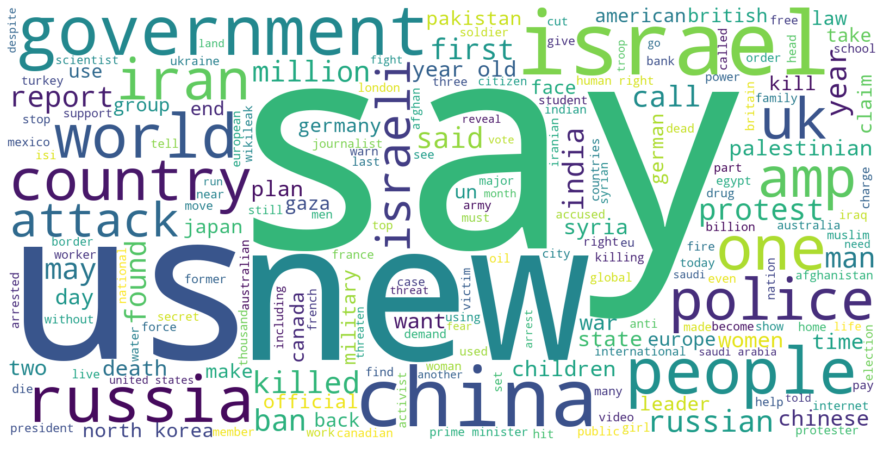

In [35]:
# Generate a word cloud image
wordcloud = WordCloud(width=1600, height=800, background_color = "white").generate(text_all)

# Display the generated image
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

Az adathalmaz véletlenszerű sorbarendezése.

In [36]:
# Do the shuffle
for i in range(SHUFFLE_CYCLE):
  df_sum_news_labels = shuffle(df_sum_news_labels, random_state = rs)

# Reset the index
df_sum_news_labels.reset_index(inplace=True, drop=True)

# Show the data frame
df_sum_news_labels

,Label,News
0,1,whisky saves man eyesight blinded vodkainterne...
1,1,hidden massacre tamil civilians killed final t...
2,1,nasa backed fusion engine could cut mars trip ...
3,0,canada greenland set polar bear commission koh...
4,0,iceland broke rules got away pakistan demanded...
...,...,...
5932,1,jaguar land rover sues chinese automobile comp...
5933,0,hamas leader says truce gaza without end israe...
5934,0,chinese school bus crash kills childrennorth k...
5935,1,gauck limiting refugee numbers unethical plast...


Az adathalmazom felbontása tanító, validáló és teszt adathalmazra. 72% tanító, 8% validáló és 20% teszt adathalmazra.

In [37]:
# Create datasets
news_string = (df_sum_news_labels['News'].values).astype('U')
 
INPUT_SIZE = len(df_sum_news_labels)
# 80% train -> 9% valid, 81% train; 10% test
TRAIN_SIZE = int(TRAIN_SPLIT * INPUT_SIZE) 
VALID_SIZE = int(VALIDATION_SPLIT * TRAIN_SIZE)

# Show the lengths
print(INPUT_SIZE, TRAIN_SIZE, VALID_SIZE)

5937 4749 474


In [38]:
# Create the train data set
train_dataset = df_sum_news_labels[:TRAIN_SIZE - VALID_SIZE] 

# Show it
train_dataset

,Label,News
0,1,whisky saves man eyesight blinded vodkainterne...
1,1,hidden massacre tamil civilians killed final t...
2,1,nasa backed fusion engine could cut mars trip ...
3,0,canada greenland set polar bear commission koh...
4,0,iceland broke rules got away pakistan demanded...
...,...,...
4270,0,sources arab nations arming syrian oppositionp...
4271,1,airstrike yemen hits area refugee camp killing...
4272,0,women working chiquitas plantations honduras w...
4273,1,nazia quazi year old canadian indian woman cs ...


A tanító halmaz címkéinek arányát vizsgálom meg a következőkben a korábbiakhoz hasonlóan.

In [39]:
# Groupby by label
labels = train_dataset.groupby("Label")

# Summary statistic of all countries
labels.describe().head()

News                                                               
      count unique                                                top freq
Label                                                                     
0      1993   1993  police used terror powers spy officers blowing...    1
1      2282   2282  russian soldier surrounded isis calls airstrik...    1

In [40]:
# Get the counts for labels
label_0_count = len(labels.get_group(0))
label_1_count = len(labels.get_group(1))

# Get the summary
label_sum = label_0_count + label_1_count

# The percentages
percentage_0 = label_0_count / label_sum
percentage_1 = label_1_count / label_sum

# Show
print(f"0 Labels percentage: {percentage_0*100:.2f}%\n")
print(f"1 Labels percentage: {percentage_1*100:.2f}%")

assert percentage_0 < 0.55 
assert percentage_0 > 0.45 

0 Labels percentage: 46.62%

1 Labels percentage: 53.38%


In [41]:
# Create the validation data set
valid_dataset = df_sum_news_labels[TRAIN_SIZE - VALID_SIZE:TRAIN_SIZE] 

# Show it
valid_dataset

,Label,News
4275,1,christian preacher arrested saying homosexuali...
4276,1,austria recognizes armenian genocideman forms ...
4277,1,declares nigeria ebola free days casespacific ...
4278,0,musk wozniak hawking urge ban ai autonomous we...
4279,0,civilians killed protesters chide silent wests...
...,...,...
4744,1,scottish govt approves windfarm opposed donald...
4745,1,wikileaked cable based calculations campaign o...
4746,0,white house cuba deal returning guantanamo bay...
4747,1,fifa president sepp blatter uefa boss michel p...


A validáló adathalmaz címkéinek az arányát vizsgálom meg ezek után.

In [42]:
# Groupby by label
labels = valid_dataset.groupby("Label")

# Summary statistic of all countries
labels.describe().head()

News                                                               
      count unique                                                top freq
Label                                                                     
0       217    217  chinese communist party leaders plan first cen...    1
1       257    257  iran day rage green movement leaders embarass ...    1

In [43]:
# Get the counts for labels
label_0_count = len(labels.get_group(0))
label_1_count = len(labels.get_group(1))

# Get the summary
label_sum = label_0_count + label_1_count

# The percentages
percentage_0 = label_0_count / label_sum
percentage_1 = label_1_count / label_sum

# Show
print(f"0 Labels percentage: {percentage_0*100:.2f}%\n")
print(f"1 Labels percentage: {percentage_1*100:.2f}%")

assert percentage_0 < 0.55 
assert percentage_0 > 0.45 

0 Labels percentage: 45.78%

1 Labels percentage: 54.22%


In [44]:
# Create the test data set
test_dataset = df_sum_news_labels[TRAIN_SIZE:]

# Show it
test_dataset

,Label,News
4749,0,without us aid israeli state would fail israel...
4750,1,girl get vaccination shots court overrules mum...
4751,0,prominent iranian official recently suggested ...
4752,0,mo ibrahim prize annual prize given good gover...
4753,1,new zealand mp demoted suggesting homeopathy u...
...,...,...
5932,1,jaguar land rover sues chinese automobile comp...
5933,0,hamas leader says truce gaza without end israe...
5934,0,chinese school bus crash kills childrennorth k...
5935,1,gauck limiting refugee numbers unethical plast...


Végül a teszt adathalmaz címkéit tekintem át.

In [45]:
# Groupby by label
labels = test_dataset.groupby("Label")

# Summary statistic of all countries
labels.describe().head()

News                                                               
      count unique                                                top freq
Label                                                                     
0       553    553  israel seized acres palestinian land build set...    1
1       635    635  harassers women cairo face wrath vigilantes gr...    1

In [46]:
# Get the counts for labels
label_0_count = len(labels.get_group(0))
label_1_count = len(labels.get_group(1))

# Get the summary
label_sum = label_0_count + label_1_count

# The percentages
percentage_0 = label_0_count / label_sum
percentage_1 = label_1_count / label_sum

# Show
print(f"0 Labels percentage: {percentage_0*100:.2f}%\n")
print(f"1 Labels percentage: {percentage_1*100:.2f}%")

assert percentage_0 < 0.55 
assert percentage_0 > 0.45 

0 Labels percentage: 46.55%

1 Labels percentage: 53.45%


Ezek lementése .tsv fájlokba, hogy majd betölthessem a pyTorch modulnak a későbbiekben.

In [47]:
# Save them without the indexes
train_dataset.to_csv('drive/MyDrive/train.tsv', sep = '\t', index=False)
valid_dataset.to_csv('drive/MyDrive/valid.tsv', sep = '\t', index=False)
test_dataset.to_csv('drive/MyDrive/test.tsv', sep = '\t', index=False)

### Szótár létrehozása

Az n-gram modell létrehozását segítő függvény definiálása.

In [48]:
def generate_ngrams(input):
    n_grams = []
    n_values = []
    output = []

    for n_value in range(N_VALUE_RANGE_START, N_VALUE_RANGE_END + 1):
        n_values.append(n_value)

    for n_value in n_values:
        n_grams.append(set(zip(*[input[i:] for i in range(n_value)])))

    for n_gram in n_grams:
        for element in n_gram:
            output.append(' '.join(element))

    return output

Az algoritmus tesztelése.

In [49]:
generate_ngrams(['This', 'stock', 'is', 'stronk'])

['stock is stronk', 'This stock is', 'This stock is stronk']

A kódolandó szövegek és a címkék formátumának a megadása. Az n-gram modell beállítása is itt történik.

In [50]:
NEWS = data.Field(tokenize = 'spacy', 
                  preprocessing = generate_ngrams,
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)

LABELS = data.LabelField(dtype = torch.float)

Az adathalmazok betöltése a pyTorch modulhoz.

In [51]:
fields = [('labels', LABELS), ('news', NEWS)]

In [52]:
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = "drive/MyDrive",
                                        train = "train.tsv",
                                        validation = "valid.tsv",
                                        test = "test.tsv",
                                        format = "tsv",
                                        fields = fields,
                                        skip_header = True
)

A betöltött adathalmazok első elemeinek a megjelenítése.

In [53]:
print(vars(train_data[0]))
print(vars(valid_data[0]))
print(vars(test_data[0]))

{'labels': '1', 'news': ['secure amp slower', 'state abstainingaustralians think', 'packs u n', 'emir poem rt', 'cut syriaun general', 'general assembly recognizes', 'indiafrance tells uk', 'worse branded packs', 'service hitler strange', 'update decades old', 'open internet behind', 'one could violate', 'leaving users less', 'users less secure', 'saves man eyesight', 'hitler strange afterlife', 'seem attempting quiet', 'decide open internet', 'treaty certain countries', 'new mandatory plain', 'coup updating one', 'lakshmi mittal sell', 'behind closed doors', 'sell nationaliseqatari poet', 'n decide open', 'doors goal update', 'think cigarettes new', 'jailed life insulting', 'eyesight blinded vodkainternet', 'insulting emir poem', 'attempting quiet coup', 'could violate rights', 'assembly recognizes palestine', 'syriaun general assembly', 'closed doors goal', 'afterlife indiafrance tells', 'mittal sell nationaliseqatari', 'palestine state abstainingaustralians', 'strange afterlife indi

#### Előtanított vektorok letöltése és mentése

Előtanult vektorok használata a szótár létrehozásához, csak a tanító adathalmazt lehet felhasználni.

Az előtanított szó vektorok betöltése (GloVe). Forrás:Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: https://nlp.stanford.edu/pubs/glove.pdf

In [54]:
if NEW_VOCAB is True and N_GRAM is False:
  NEWS.build_vocab(train_data, 
                  max_size = MAX_VOCAB_SIZE, 
                  vectors = "glove.6B.100d", 
                  unk_init = torch.Tensor.normal_)

  LABELS.build_vocab(train_data)

  print("Done!")

A szótárhoz tartozó vektorok elmentése, hogy legközelebb ne kelljen újra letölteni ezt a nagy adathalmazt.

In [55]:
if NEW_VOCAB is True and N_GRAM is False:
  torch.save(NEWS.vocab.vectors, "drive/MyDrive/news_vocab_vectors.pt")

  print("Done!")

#### Előtanított vektorok betöltése

A szótárhoz tartozó vektorok betöltése következik a korábban lementett, előtanított vektorok alapján.

In [56]:
if NEW_VOCAB is False or N_GRAM is True:
  NEWS.build_vocab(train_data,
                   max_size = MAX_VOCAB_SIZE)

  LABELS.build_vocab(train_data)

  if N_GRAM is False:
    NEWS.vocab.vectors = torch.load("drive/MyDrive/news_vocab_vectors.pt")

    print("Done!")

  print("Done!")

Done!


#### Szótár ellenőrzése és előkészítés

A létrehozott szótár ellenőrzése.

In [57]:
print(f"Unique tokens in TEXT vocabulary: {len(NEWS.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABELS.vocab)}")

Unique tokens in TEXT vocabulary: 10002
Unique tokens in LABEL vocabulary: 2


A leggyakoribb szavak és a címkék ellenőrzése.

In [58]:
print(NEWS.vocab.freqs.most_common(20))
print(LABELS.vocab.stoi)

[('kim jong un', 59), ('year old girl', 57), ('kim jong il', 41), ('osama bin laden', 35), ('human rights watch', 34), ('world war ii', 31), ('president vladimir putin', 30), ('nobel peace prize', 28), ('president barack obama', 28), ('great barrier reef', 27), ('bashar al assad', 27), ('first time since', 26), ('president bashar al', 25), ('president bashar al assad', 23), ('female genital mutilation', 23), ('human rights abuses', 22), ('south china sea', 22), ('x post r', 21), ('australian prime minister', 21), ('founder julian assange', 20)]
defaultdict(None, {'1': 0, '0': 1})


A futtató eszköz és az iterátorok definiálása.

In [59]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Show it
print(device)

#Set the iterators for the data
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort_key = lambda x: x.news, #sort by n attribute (quote)
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

cpu


A batch-ekhez tartozó iterátorok kiíratása.

In [60]:
print('Train:')
for batch in train_iterator:
    print(batch)
    break
    
print('Valid:')
for batch in valid_iterator:
    print(batch)
    break
    
print('Test:')
for batch in test_iterator:
    print(batch)
    break

Train:

[torchtext.data.batch.Batch of size 32]
	[.labels]:[torch.FloatTensor of size 32]
	[.news]:('[torch.LongTensor of size 455x32]', '[torch.LongTensor of size 32]')
Valid:

[torchtext.data.batch.Batch of size 32]
	[.labels]:[torch.FloatTensor of size 32]
	[.news]:('[torch.LongTensor of size 432x32]', '[torch.LongTensor of size 32]')
Test:

[torchtext.data.batch.Batch of size 32]
	[.labels]:[torch.FloatTensor of size 32]
	[.news]:('[torch.LongTensor of size 372x32]', '[torch.LongTensor of size 32]')


### A modell felépítése

LSTM modell felépítése.

In [61]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        #for more than one layer
        if N_LAYERS > 1:
          self.rnn = nn.LSTM(embedding_dim, #input size
                            hidden_dim, #features in hidden state
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout)
        
        #for one layer only
        if N_LAYERS is 1:
          self.rnn = nn.LSTM(embedding_dim, #input size
                            hidden_dim, #features in hidden state
                            num_layers=n_layers, 
                            bidirectional=bidirectional)

        if BIDIRECTIONAL is True:        
          self.fc = nn.Linear(2 * hidden_dim, output_dim)

        if BIDIRECTIONAL is False:        
          self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        #print(text.size()) # 134 | 32

        embedded = self.dropout(self.embedding(text))

        #print(embedded.size()) # 134 | 32 | 100
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        #print(hidden.size()) # 3 | 32 | 64
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        #this is for Bidirectional only!
        if BIDIRECTIONAL is True:
          hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        #this is for One direction
        if BIDIRECTIONAL is False:
          hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim * num directions] -> 32 | 64
        #print(hidden.size())

        return self.fc(hidden)

LSTM modell példányosítása.

In [62]:
INPUT_DIM = len(NEWS.vocab)
PAD_IDX = NEWS.vocab.stoi[NEWS.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

A modell tanítható paramétereinek megvizsgálása.

In [63]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,421,769 trainable parameters


A korábban létrehozott szótár használata a modell esetében.

In [64]:
if N_GRAM is False:
    pretrained_embeddings = NEWS.vocab.vectors

    print(pretrained_embeddings.shape)

Az előre inicializált súlyok lecserélére az előtanítottakra.

In [65]:
if N_GRAM is False:
    model.embedding.weight.data.copy_(pretrained_embeddings[0:MAX_VOCAB_SIZE + 2])

A térköz és az ismeretlen kódok súlyának nullára állítása.

In [66]:
UNK_IDX = NEWS.vocab.stoi[NEWS.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7289, -0.7336,  1.5624,  ..., -0.5592, -0.4480, -0.6476],
        ...,
        [ 1.1877, -0.1007, -0.9998,  ..., -0.8427, -0.4373,  0.5312],
        [ 1.2414,  0.7652,  0.5544,  ..., -0.1540,  0.3626, -1.0382],
        [-0.7707,  1.2644,  0.0727,  ..., -0.4206, -0.1342,  0.5148]])


Esetleges üres súlyok keresése a kódoló rétegben. Ha megegyezik a szótár max nagyságával a kiírt akkor megfelelő.

In [67]:
weights = torch.nonzero(model.embedding.weight.data, as_tuple = True)[0]

print(torch.unique(weights).shape)
print(MAX_VOCAB_SIZE)

assert list(torch.unique(weights).shape)[0] == MAX_VOCAB_SIZE

torch.Size([10000])
10000


Ha a konfiguráláskor letiltottam a kódoló réteg (embedding layer) tanítását, akkor azt itt kapcsolom ki.

In [68]:
if FREEZE_EMB is True:
    model.embedding.weight.requires_grad = False

    print(f'The model has {count_parameters(model):,} trainable parameters')

### A modell tanításának előkészítése

A modell tanítása következik, amit először az optimalizáló függvény meghatározásával kezdem.

In [69]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Ezek után a költséggfüggvény definiálása következik, majd a modellel együtt az eszközre illesztése.

In [70]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

A pontosság számítására használandó függvény definiálása.

In [71]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

A tanító függvény definiálása.

In [72]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() # turn on drop out
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.news

        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.labels)
        
        acc = binary_accuracy(predictions, batch.labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

A modell tesztelésének definiálása.

In [73]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval() # turn off drop out
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.news
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.labels)
            
            acc = binary_accuracy(predictions, batch.labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Az epoch-ok idejének mérésére használt függvény definiálása.

In [74]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### A modell tanítása és kiértékelése

A modell tanítása.

In [76]:
best_valid_loss = float('inf')

no_improve_counter = 0
last_valid_acc = 0

train_loss_array = []
train_acc_array = []
valid_loss_array = []
valid_acc_array = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_loss_array.append(train_loss)
    train_acc_array.append(train_acc)
    valid_loss_array.append(valid_loss)
    valid_acc_array.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'drive/MyDrive/best-model.pt')

    # early leave
    no_improvements = ""

    if last_valid_acc > valid_acc:
        best_valid_loss = valid_loss
        no_improve_counter = no_improve_counter + 1
        no_improvements = "| There were no improvements on the validation set!"
    else:
        no_improve_counter = 0

    last_valid_acc = valid_acc

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s {no_improvements}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if no_improve_counter is 5:
      print(f'The model is not improving, going to stop.')
      break

    if train_acc > 0.95:
      print(f'The model training is finished.')
      break 

torch.save(model.state_dict(), 'drive/MyDrive/last-model.pt')      

KeyboardInterrupt: ignored

A tanítási és validációs metrikák ábrázolása.

NameError: ignored

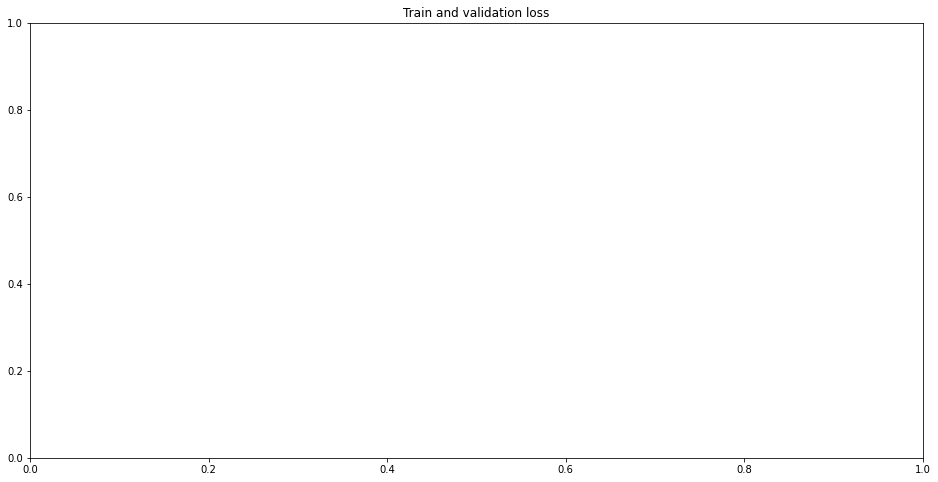

In [75]:
# Visualize the training
plt.figure(figsize=(16,8))
plt.title('Train and validation loss')
plt.plot(train_loss_array, color = "green", label = "Train loss")
plt.plot(valid_loss_array, color = "blue", label = "Valid loss")
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.legend(fontsize=18)
plt.show()

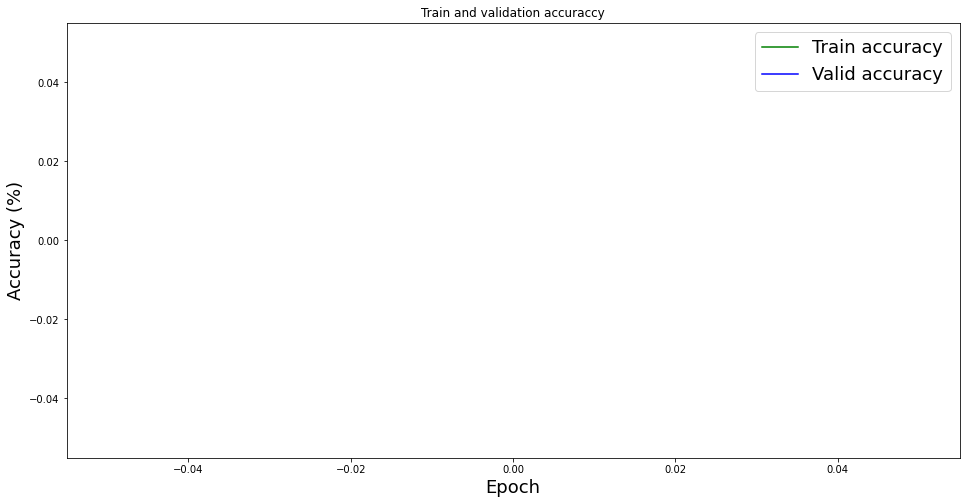

In [78]:
# Visualize the training
plt.figure(figsize=(16,8))
plt.title('Train and validation accuraccy')
plt.plot(train_acc_array, color = "green", label = "Train accuracy")
plt.plot(valid_acc_array, color = "blue", label = "Valid accuracy")
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Accuracy (%)',fontsize=18)
plt.legend(fontsize=18)
plt.show()

### A modell tesztelése

A modell tesztelése.

In [78]:
model.load_state_dict(torch.load('drive/MyDrive/best-model.pt', map_location=torch.device('cpu')))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'-- Best model --')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

model.load_state_dict(torch.load('drive/MyDrive/last-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'\n-- Last model --')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

-- Best model --
Test Loss: 1.540 | Test Acc: 52.47%


RuntimeError: ignored

ROC metrika megjelenítése a legjobb modellre.

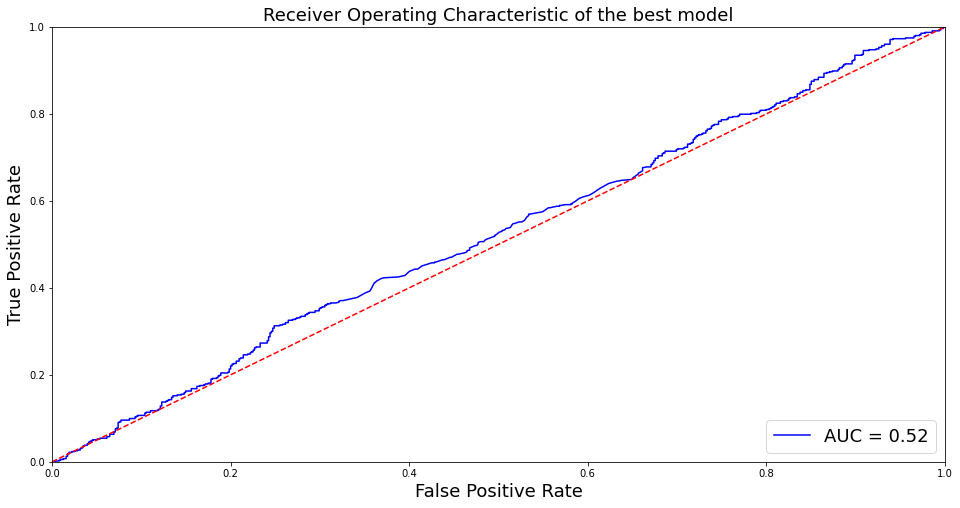

In [82]:
model.load_state_dict(torch.load('drive/MyDrive/best-model.pt'))

model.eval() # turn off drop out

predictions = []
labels = []

# Collect predictions and labels
for batch in test_iterator:
  text, text_lengths = batch.news

  predictions.append(model(text, text_lengths).squeeze(1))

  labels.append(batch.labels)

# Convert to numpy
pred_tensor = torch.cat(predictions).cpu()
labels_tensor = torch.cat(labels).cpu()

# Get the metrics
fpr, tpr, threshold = metrics.roc_curve(labels_tensor.detach().numpy(), pred_tensor.detach().numpy())
roc_auc = metrics.auc(fpr, tpr)

# Plot
plt.figure(figsize=(16,8))
plt.title('Receiver Operating Characteristic of the best model', fontsize = 18)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 18)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.show()

ROC metrika megjelenítése a legutolsó tanított modellemre.

In [81]:
model.load_state_dict(torch.load('drive/MyDrive/last-model.pt'))

model.eval() # turn off drop out

predictions = []
labels = []

# Collect predictions and labels
for batch in test_iterator:
  text, text_lengths = batch.news

  predictions.append(model(text, text_lengths).squeeze(1))

  labels.append(batch.labels)

# Convert to numpy
pred_tensor = torch.cat(predictions).cpu()
labels_tensor = torch.cat(labels).cpu()

# Get the metrics
fpr, tpr, threshold = metrics.roc_curve(labels_tensor.detach().numpy(), pred_tensor.detach().numpy())
roc_auc = metrics.auc(fpr, tpr)

# Plot
plt.figure(figsize=(16,8))
plt.title('Receiver Operating Characteristic of the last model', fontsize = 18)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize = 18)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.show()

RuntimeError: ignored

A többi modellel való összehasonlításhoz szükséges táblázat megalkotása.

In [79]:
# compare with other models
# combine the news and remove the 'b' char at the beginning
# no other preprocess, the tokenizer will take care of it

model.load_state_dict(torch.load('drive/MyDrive/best-model.pt', map_location=torch.device('cpu')))

ROWS = 25

# Get column names
combined_column_names = []
for column in df_for_test.columns:
  combined_column_names.append(column)

# 2D array creation for the news based on macros
COLUMNS = len(df_for_test)
news_sum = [[0 for i in range(COLUMNS)] for j in range(int((len(combined_column_names) - 1) / ROWS))]  

# Merge the news
for row in range(len(df_for_test)):
  for column in range(int((len(combined_column_names) - 1) / ROWS)):
    temp = ""
    news = ""
    for word in range(ROWS):
      news = df_for_test[combined_column_names[(column * ROWS) + (word + 1)]][row]
      # Remove the b character at the begining of the string
      if news[0] is "b":
        news = " " + news[1:]
      temp = temp + news
    news_sum[column][row] = temp

# Drop the old columns
for column in range(len(combined_column_names) - 1):
  df_for_test.drop(combined_column_names[column + 1], axis = 1, inplace = True)

# Create the new columns with the merged news
for column in range(int((len(combined_column_names) - 1) / ROWS)):
  colum_name = "News_" + str(column + 1)
  df_for_test[colum_name] = news_sum[column]

# Show the DataFrame
df_for_test.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Label,News_1
Date,,
2016-06-20,1,A staggering 87 percent of Venezuelans say the...
2016-06-21,1,An Australian athlete who has competed in six ...
2016-06-22,0,German government agrees to ban fracking indef...
2016-06-23,1,Today The United Kingdom decides whether to re...
2016-06-24,0,David Cameron to Resign as PM After EU Referen...


In [80]:
# create new dataset without the dates
news_sum = []
label_sum = []

# Get the column names
combined_column_names = []
for column in df_for_test.columns:
  combined_column_names.append(column)

# Connect the merged news with the labels
for column in range(len(df_for_test)):
  for row in range(len(combined_column_names) - 1):
    news_sum.append(df_for_test[combined_column_names[row + 1]][column])
    label_sum.append(df_for_test[combined_column_names[0]][column])

# Create the new DataFrame
df_sum_news_labels = pd.DataFrame(data = label_sum, index = None, columns = ["Label"])
df_sum_news_labels["News"] = news_sum

# Show it
df_sum_news_labels.head()

,Label,News
0,1,A staggering 87 percent of Venezuelans say the...
1,1,An Australian athlete who has competed in six ...
2,0,German government agrees to ban fracking indef...
3,1,Today The United Kingdom decides whether to re...
4,0,David Cameron to Resign as PM After EU Referen...


In [81]:
# check and delete the null length cells
news_sum = df_sum_news_labels["News"]
null_indexes = []
index = 0

for line in news_sum:
  if line is "":
    null_indexes.append(index)
  index = index + 1

print(null_indexes)

for row in null_indexes:
  df_sum_news_labels = df_sum_news_labels.drop(row)

news_sum = df_sum_news_labels["News"]
null_indexes = []
index = 0

for line in news_sum:
  if line is "":
    null_indexes.append(index)
  index = index + 1
  
assert len(null_indexes) is 0

[]


In [82]:
df_sum_news_labels

,Label,News
0,1,A staggering 87 percent of Venezuelans say the...
1,1,An Australian athlete who has competed in six ...
2,0,German government agrees to ban fracking indef...
3,1,Today The United Kingdom decides whether to re...
4,0,David Cameron to Resign as PM After EU Referen...
5,0,Barclays and RBS shares suspended from trading...
6,1,"2,500 Scientists To Australia: If You Want To ..."
7,1,Explosion At Airport In IstanbulYemeni former ...
8,1,Jamaica proposes marijuana dispensers for tour...
9,1,A 117-year-old woman in Mexico City finally re...


In [83]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = generate_ngrams([tok.text for tok in nlp.tokenizer(sentence)])
    indexed = [NEWS.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [85]:
predict_raw = []
predict_label = []

for row in range(len(df_sum_news_labels)):
    sent_temp = predict_sentiment(model, df_sum_news_labels["News"][row])
    predict_raw.append(sent_temp)
    predict_label.append(round(sent_temp))

print(predict_raw)
print("\n\n")
print(predict_label)

[0.4603252410888672, 0.1490498036146164, 0.4603252410888672, 0.488603800535202, 0.5045595169067383, 0.4603232145309448, 0.4603252410888672, 0.46032482385635376, 0.5041316747665405, 0.44783246517181396]



[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]


In [86]:
# create the table
df_result = df_for_test.drop("News_1", axis=1)

df_result["Raw"] = predict_raw
df_result["Sentiment"] = predict_label

match = []
for row in range(len(df_result)):
    if df_result["Label"][row] == df_result["Sentiment"][row]:
        match.append(1)
    else:
        match.append(0)

df_result["Match"] = match

df_result

,Label,Raw,Sentiment,Match
Date,,,,
2016-06-20,1,0.460325,0,0
2016-06-21,1,0.149050,0,0
2016-06-22,0,0.460325,0,1
2016-06-23,1,0.488604,0,0
2016-06-24,0,0.504560,1,0
2016-06-27,0,0.460323,0,1
2016-06-28,1,0.460325,0,0
2016-06-29,1,0.460325,0,0
2016-06-30,1,0.504132,1,1
